In [ ]:
#%%time
from setup import *

start = time.time()
restart = time.time()
num_verts = 40
ramsey = [3,10]
beta = 0.8


num_colorings = 256
num_steps = 100000
report_period = 10

get_cliques = False
printout = False
print_coloring = 0
#np.random.seed(42)

exec(open("ramsey_parallel.py").read())
print("setup time = %.2f"%(time.time()-restart))
restart = time.time()
problem_counts_current = count_problems(colorings,printout)

problem_counts_proposed = problem_counts_current.copy()
problem_counts_best = problem_counts_current.copy()
colorings_best = colorings.copy()
best_step = np.zeros(num_colorings).astype('uint32')


def print_colorings(idx=None):
    df = pd.DataFrame(colorings)
    df.columns = [tuple(e) for e in edge_idx_to_pair]
    if idx is not None:
        df = df.loc[idx]    
    display(df)


def print_status(best_step,problem_counts_best):
    df = pd.DataFrame()
    df['best step'] = best_step
    df['problems'] = problem_counts_best
    df = df.T
    idx = np.argmin(problem_counts_best)#.argmin()
    s = 'best='+str(idx)
    df[s] = df[idx]
    display(df)

print("step:%u,  time = %f"%(0,(time.time()-restart)))
restart = time.time()
print_status(best_step,problem_counts_best)

print("Begin Markov Chain")
#edge_color_old = np.zeros(num_colorings).astype('uint8')
rows = np.arange(num_colorings)
for step in range(1,num_steps+1):
    found = (problem_counts_current == 0)
    if np.any(found):
        found = found.nonzero()
        print("FOUND AT LEAST ONE WITH NO PROBLEMS: %s"%found)
        print("step:%u,  total time = %f"%((step-1),(time.time()-start)))
        print_status(best_step,problem_counts_best)
        print_colorings(found)
        break

    change_edge = np.random.randint(0, tot_edges, size=num_colorings).astype('uint16')
    colorings[rows,change_edge] += 1
    colorings[rows,change_edge] %= 2
    #delta_color = np.random.randint(1, num_colors, size=num_colorings).astype('uint8')
#         for c in range(num_colorings):
#             e = change_edge[c]
#             edge_color_old[c] = colorings[c,e]
#             colorings[c,e] = ((colorings[c,e] + delta_color[c]) % num_colors)


    problem_counts_gpu *= 0
    problem_counts_proposed = count_problems(colorings,printout)

    for c in range(num_colorings):
        if(problem_counts_current[c] >= problem_counts_proposed[c]):
            problem_counts_current[c] = problem_counts_proposed[c]

            if(problem_counts_best[c] > problem_counts_proposed[c]):
                problem_counts_best[c] = problem_counts_proposed[c]
                colorings_best[c,:] = colorings[c,:].copy()
                best_step[c] = step

        else:
            prob_diff = problem_counts_proposed[c] - problem_counts_current[c]
            accept = np.exp(-1 * beta * prob_diff)
            r = np.random.random()
            if r <= accept:
                #print(" but I accept it anyway.")
                problem_counts_current[c] = problem_counts_proposed[c]
            else:
                #print(" and I reject it.")
                #colorings[c,change_edge[c]] = edge_color_old[c]
                colorings[c,change_edge[c]] += 1
                colorings[c,change_edge[c]] %= 2
    if(step % report_period == 0):
        delta_t = time.time()-restart
        print("step:%u,  sec/step = %.2f,  total time = %.2f"%(step, delta_t/report_period, (time.time()-start)))
        restart = time.time()
        print_status(best_step,problem_counts_best)


setup time = 0.49
step:0,  time = 321.277757


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=247
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,1168,1087,1144,1218,1121,1225,1253,1135,1244,1196,...,953,1165,1118,1454,1210,1155,1208,1006,1352,953


Begin Markov Chain
step:10,  sec/step = 321.54,  total time = 3537.18


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=36
best step,10,10,9,8,10,9,8,10,10,9,...,10,10,8,10,10,10,8,8,9,10
problems,1105,1047,1098,1183,1048,1158,1240,1066,1183,1179,...,933,1122,1087,1384,1148,1098,1148,962,1297,915


step:20,  sec/step = 321.74,  total time = 6754.55


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=36
best step,20,19,18,20,19,20,19,20,19,20,...,19,18,20,20,19,19,20,19,20,19
problems,1084,991,1064,1157,1024,1110,1177,1023,1140,1135,...,896,1099,1039,1343,1092,1057,1104,940,1257,869


step:30,  sec/step = 321.98,  total time = 9974.38


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,29,30,28,30,29,24,25,20,30,30,...,29,30,30,28,27,28,28,28,30,30
problems,1039,955,1026,1100,973,1088,1157,1023,1079,1079,...,878,1027,1001,1300,1044,1037,1056,900,1190,825


step:40,  sec/step = 322.19,  total time = 13196.25


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,40,38,39,40,38,39,40,40,39,40,...,38,38,40,40,40,40,38,38,40,40
problems,974,914,996,1053,947,1052,1135,988,1028,1027,...,840,980,974,1202,986,995,1039,856,1162,787


step:50,  sec/step = 322.41,  total time = 16420.39


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,50,49,47,50,44,48,49,48,50,49,...,50,47,48,50,50,49,47,50,50,50
problems,947,871,964,998,919,1041,1099,982,977,987,...,803,946,954,1150,961,936,1011,803,1116,725


step:60,  sec/step = 322.65,  total time = 19646.87


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,60,52,60,60,58,60,60,58,60,60,...,59,60,60,59,60,55,60,60,60,57
problems,908,854,930,957,888,1013,1045,962,949,954,...,772,900,912,1096,926,925,959,785,1070,684


step:70,  sec/step = 322.87,  total time = 22875.60


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,70,67,68,67,70,68,69,70,68,70,...,70,67,68,69,69,70,70,70,70,69
problems,879,847,909,950,870,991,1023,921,914,893,...,745,873,881,1051,890,871,929,751,1036,650


step:80,  sec/step = 323.10,  total time = 26106.56


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,78,79,80,78,80,79,74,80,79,80,...,76,80,78,80,78,78,80,74,79,76
problems,844,823,867,915,852,954,997,863,890,860,...,723,843,871,1010,870,856,880,735,992,623


step:90,  sec/step = 323.32,  total time = 29339.76


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,89,90,90,89,88,90,90,90,90,90,...,90,90,89,90,90,88,90,87,86,89
problems,815,802,822,874,826,914,950,816,819,815,...,716,805,845,966,812,820,866,714,951,596


step:100,  sec/step = 323.60,  total time = 32575.74


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,98,100,99,99,100,99,100,100,100,96,...,100,98,100,100,99,100,99,100,100,99
problems,770,761,801,843,787,889,913,762,783,788,...,672,796,809,929,785,786,830,667,900,562


step:110,  sec/step = 323.83,  total time = 35814.04


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,107,110,110,109,110,109,110,109,110,109,...,108,109,109,110,110,110,110,110,110,106
problems,763,724,757,820,759,842,885,747,761,768,...,645,758,773,884,760,758,806,627,875,538


step:120,  sec/step = 324.05,  total time = 39054.50


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,120,117,118,120,117,117,119,120,119,120,...,119,117,118,120,119,120,120,117,116,117
problems,746,686,724,795,741,811,847,716,734,737,...,609,724,731,861,732,704,785,590,832,513


step:130,  sec/step = 324.28,  total time = 42297.27


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,126,130,128,130,128,129,129,128,130,130,...,130,130,129,130,130,127,127,130,129,128
problems,734,656,689,763,731,778,797,691,686,712,...,587,690,691,824,703,683,743,578,805,491


step:140,  sec/step = 324.53,  total time = 45542.62


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,140,140,131,139,140,137,139,140,140,139,...,140,140,139,139,140,139,133,136,139,139
problems,715,615,685,725,708,768,788,673,651,691,...,581,633,670,808,692,662,727,566,764,468


step:220,  sec/step = 326.65,  total time = 71606.19


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,220,219,220,217,220,220,220,210,213,217,...,220,205,214,218,220,220,218,220,219,219
problems,530,459,492,558,494,591,590,471,492,525,...,455,492,505,578,521,463,556,384,558,330


step:230,  sec/step = 326.90,  total time = 74875.16


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,230,229,230,230,230,230,230,229,230,230,...,230,226,225,230,228,227,227,230,229,230
problems,508,429,456,535,460,546,568,446,479,489,...,436,483,494,547,511,438,547,367,535,316


step:240,  sec/step = 327.24,  total time = 78147.52


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,240,237,240,236,240,240,235,239,240,237,...,238,240,239,239,239,240,240,231,240,234
problems,494,416,437,518,437,536,546,435,457,477,...,429,470,475,530,481,429,530,363,508,310


step:250,  sec/step = 327.49,  total time = 81422.47


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,250,248,245,250,249,250,250,249,249,250,...,250,250,250,245,250,249,248,246,249,245
problems,469,414,426,483,414,527,518,426,436,465,...,414,447,467,527,460,415,517,360,486,307


step:260,  sec/step = 327.71,  total time = 84699.60


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,257,260,245,260,256,257,254,259,257,260,...,257,251,257,258,259,252,258,260,253,258
problems,461,404,426,464,409,514,499,413,417,444,...,399,441,448,516,444,404,505,341,480,303


step:270,  sec/step = 328.03,  total time = 87979.87


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,270,262,270,269,266,267,267,268,267,269,...,270,270,269,269,270,270,270,270,269,268
problems,446,390,401,461,393,507,481,398,410,431,...,382,413,425,500,427,383,458,334,452,291


step:280,  sec/step = 328.31,  total time = 91263.01


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,270,280,280,280,277,279,280,278,280,280,...,280,280,280,279,279,278,280,278,279,280
problems,446,381,370,439,389,472,465,383,383,418,...,358,399,410,477,408,380,451,324,441,284


step:290,  sec/step = 328.56,  total time = 94548.60


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=98
best step,285,290,289,289,288,284,290,289,289,289,...,288,289,285,290,290,290,287,290,290,286
problems,430,367,354,413,386,454,450,376,382,404,...,337,379,399,463,395,371,434,310,411,283


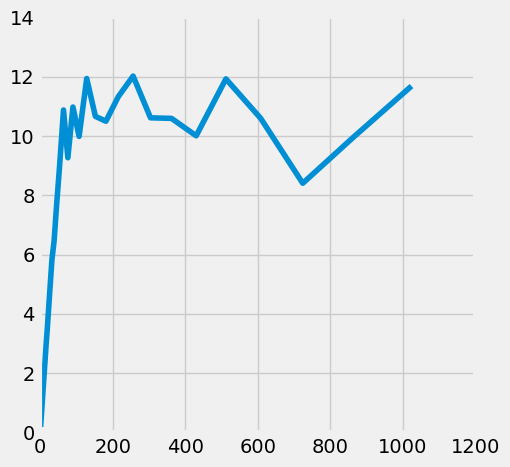

,threads/sec,sec/step
1,0.187,5.345
2,0.380,5.263
3,0.566,5.299
4,0.755,5.300
5,0.935,5.349
6,1.132,5.300
7,1.321,5.301
8,1.509,5.302
9,1.681,5.355
10,1.858,5.383


In [13]:
plt.plot(thread_counts,thread_counts/run_times[-1,:])
plt.show()
#display(list(zip(thread_counts,thread_counts/run_times[-1,:])))
df = pd.DataFrame(index=thread_counts)
df['threads/sec'] = thread_counts/run_times[-1,:]
df['sec/step'] = run_times[-1,:]
display(df)

In [1]:
#%%time
from setup import *

num_steps = 1

A = np.arange(1,16,1)
d = .25
p = np.arange(4,10+d,d)
b = np.ones_like(p)*2
B = np.floor(np.power(b,p))
thread_counts = np.hstack([A,B]).astype('uint16')

run_times = np.zeros([num_steps+1,len(thread_counts)]).astype('float')

for (run,nc) in enumerate(thread_counts):    
    num_colorings = int(nc)
    print("\n\nnum colorings = %u"%num_colorings)
    start = time.time()
    num_verts = 32
    ramsey = [3,10]
    beta = 1.2

    num_colorings_set = np.arange(1)
    #num_colorings = 256
    num_steps = 1
    report_period = 1

    get_cliques = False
    printout = False
    print_coloring = 0
    np.random.seed(42)

    exec(open("ramsey_parallel.py").read())
    print("setup time = %.2f"%(time.time()-start))
    restart = time.time()
    problem_counts_current = count_problems(colorings,printout)

    problem_counts_proposed = problem_counts_current.copy()
    problem_counts_best = problem_counts_current.copy()
    colorings_best = colorings.copy()
    best_step = np.zeros(num_colorings).astype('uint32')


    def print_colorings(idx=None):
        df = pd.DataFrame(colorings)
        df.columns = [tuple(e) for e in edge_idx_to_pair]
        if idx is not None:
            df = df.loc[idx]    
        display(df)


    def print_status(best_step,problem_counts_best):
        df = pd.DataFrame()
        df['best step'] = best_step
        df['problems'] = problem_counts_best
        df = df.T
        idx = np.argmin(problem_counts_best)#.argmin()
        s = 'best='+str(idx)
        df[s] = df[idx]
        display(df)

    run_times[0,run] = time.time()-restart
    print("step:%u,  total time = %f"%(0,(time.time()-restart)))
    restart = time.time()
    print_status(best_step,problem_counts_best)

    print("Begin Markov Chain")
    #edge_color_old = np.zeros(num_colorings).astype('uint8')
    rows = np.arange(num_colorings)
    for step in range(1,num_steps+1):
        found = (problem_counts_current == 0)
        if np.any(found):
            found = found.nonzero()
            print("FOUND AT LEAST ONE WITH NO PROBLEMS: %s"%found)
            print("step:%u,  total time = %f"%((step-1),(time.time()-start)))
            print_status(best_step,problem_counts_best)
            print_colorings(found)
            break

        change_edge = np.random.randint(0, tot_edges, size=num_colorings).astype('uint16')
        colorings[rows,change_edge] += 1
        colorings[rows,change_edge] %= 2
        #delta_color = np.random.randint(1, num_colors, size=num_colorings).astype('uint8')
#         for c in range(num_colorings):
#             e = change_edge[c]
#             edge_color_old[c] = colorings[c,e]
#             colorings[c,e] = ((colorings[c,e] + delta_color[c]) % num_colors)


        problem_counts_gpu *= 0
        problem_counts_proposed = count_problems(colorings,printout)

        for c in range(num_colorings):
            if(problem_counts_current[c] >= problem_counts_proposed[c]):
                problem_counts_current[c] = problem_counts_proposed[c]

                if(problem_counts_best[c] > problem_counts_proposed[c]):
                    problem_counts_best[c] = problem_counts_proposed[c]
                    colorings_best[c,:] = colorings[c,:].copy()
                    best_step[c] = step

            else:
                prob_diff = problem_counts_proposed[c] - problem_counts_current[c]
                accept = np.exp(-1 * beta * prob_diff)
                r = np.random.random()
                if r <= accept:
                    #print(" but I accept it anyway.")
                    problem_counts_current[c] = problem_counts_proposed[c]
                else:
                    #print(" and I reject it.")
                    #colorings[c,change_edge[c]] = edge_color_old[c]
                    colorings[c,change_edge[c]] += 1
                    colorings[c,change_edge[c]] %= 2
        if(step % report_period == 0):
            run_times[step,run] = time.time()-restart
            print("step:%u,  total time = %.2f"%(step,(time.time()-restart)))
            restart = time.time()
            print_status(best_step,problem_counts_best)




num colorings = 1
setup time = 0.48
step:0,  total time = 5.260992


,0,best=0
best step,0,0
problems,577,577


Begin Markov Chain
step:1,  total time = 5.34


,0,best=0
best step,0,0
problems,577,577




num colorings = 2
setup time = 0.23
step:0,  total time = 5.252354


,0,1,best=0
best step,0,0,0
problems,577,581,577


Begin Markov Chain
step:1,  total time = 5.26


,0,1,best=0
best step,1,1,1
problems,570,574,570




num colorings = 3
setup time = 0.20
step:0,  total time = 5.286709


,0,1,2,best=0
best step,0,0,0,0
problems,577,581,685,577


Begin Markov Chain
step:1,  total time = 5.30


,0,1,2,best=0
best step,1,0,0,1
problems,568,581,685,568




num colorings = 4
setup time = 0.22
step:0,  total time = 5.285456


,0,1,2,3,best=0
best step,0,0,0,0,0
problems,577,581,685,713,577


Begin Markov Chain
step:1,  total time = 5.30


,0,1,2,3,best=1
best step,0,1,1,1,1
problems,577,575,679,702,575




num colorings = 5
setup time = 0.22
step:0,  total time = 5.331823


,0,1,2,3,4,best=0
best step,0,0,0,0,0,0
problems,577,581,685,713,711,577


Begin Markov Chain
step:1,  total time = 5.35


,0,1,2,3,4,best=0
best step,0,0,1,1,1,0
problems,577,581,678,704,703,577




num colorings = 6
setup time = 0.22
step:0,  total time = 5.285244


,0,1,2,3,4,5,best=5
best step,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,547


Begin Markov Chain
step:1,  total time = 5.30


,0,1,2,3,4,5,best=5
best step,0,0,1,1,1,1,1
problems,577,581,678,702,697,542,542




num colorings = 7
setup time = 0.22
step:0,  total time = 5.286398


,0,1,2,3,4,5,6,best=6
best step,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,517


Begin Markov Chain
step:1,  total time = 5.30


,0,1,2,3,4,5,6,best=6
best step,1,1,0,0,0,1,0,0
problems,576,574,685,713,711,541,517,517




num colorings = 8
setup time = 0.22
step:0,  total time = 5.286686


,0,1,2,3,4,5,6,7,best=6
best step,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,517


Begin Markov Chain
step:1,  total time = 5.30


,0,1,2,3,4,5,6,7,best=6
best step,0,1,0,1,0,0,1,1,1
problems,577,577,685,703,711,547,510,592,510




num colorings = 9
setup time = 0.23
step:0,  total time = 5.338480


,0,1,2,3,4,5,6,7,8,best=8
best step,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,496


Begin Markov Chain
step:1,  total time = 5.35


,0,1,2,3,4,5,6,7,8,best=8
best step,1,1,0,1,1,1,1,1,0,0
problems,568,575,685,704,707,539,510,591,496,496




num colorings = 10
setup time = 0.22
step:0,  total time = 5.365938


,0,1,2,3,4,5,6,7,8,9,best=8
best step,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,496


Begin Markov Chain
step:1,  total time = 5.38


,0,1,2,3,4,5,6,7,8,9,best=8
best step,1,1,1,1,0,0,0,1,1,1,1
problems,571,577,676,702,711,547,517,594,487,787,487




num colorings = 11
setup time = 0.22
step:0,  total time = 5.380566


,0,1,2,3,4,5,6,7,8,9,10,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,496


Begin Markov Chain
step:1,  total time = 5.40


,0,1,2,3,4,5,6,7,8,9,10,best=8
best step,0,1,0,0,1,1,1,1,0,0,1,0
problems,577,568,685,713,703,540,511,591,496,796,628,496




num colorings = 12
setup time = 0.22
step:0,  total time = 5.370540


,0,1,2,3,4,5,6,7,8,9,10,11,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,715,496


Begin Markov Chain
step:1,  total time = 5.39


,0,1,2,3,4,5,6,7,8,9,10,11,best=8
best step,0,0,0,1,1,1,0,0,0,1,1,0,0
problems,577,581,685,706,703,539,517,598,496,784,634,715,496




num colorings = 13
setup time = 0.22
step:0,  total time = 5.419664


,0,1,2,3,4,5,6,7,8,9,10,11,12,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,715,664,496


Begin Markov Chain
step:1,  total time = 5.44


,0,1,2,3,4,5,6,7,8,9,10,11,12,best=8
best step,0,1,1,1,0,1,0,1,1,0,0,0,0,1
problems,577,577,679,706,711,541,517,588,488,796,638,715,664,488




num colorings = 14
setup time = 0.22
step:0,  total time = 5.368801


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,715,664,694,496


Begin Markov Chain
step:1,  total time = 5.39


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,best=8
best step,1,1,1,1,1,0,0,1,0,1,1,0,0,1,0
problems,571,574,676,703,704,547,517,590,496,784,631,715,664,681,496




num colorings = 15
setup time = 0.23
step:0,  total time = 5.397619


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,715,664,694,564,496


Begin Markov Chain
step:1,  total time = 5.42


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,best=8
best step,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1
problems,567,577,685,713,711,540,517,598,491,796,634,715,664,694,560,491




num colorings = 16
setup time = 0.21
step:0,  total time = 5.390522


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,715,664,694,564,558,496


Begin Markov Chain
step:1,  total time = 5.41


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,best=8
best step,0,0,1,0,0,0,1,0,0,0,1,1,1,1,1,0,0
problems,577,581,680,713,711,547,511,598,496,796,631,708,655,687,560,558,496




num colorings = 19
setup time = 0.21
step:0,  total time = 5.444754


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,best=8
best step,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,638,715,664,694,564,558,565,615,749,496


Begin Markov Chain
step:1,  total time = 5.51


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,best=8
best step,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,1,1,0
problems,577,581,677,713,711,536,517,598,496,796,638,703,656,694,557,553,565,612,739,496




num colorings = 22
setup time = 0.19
step:0,  total time = 5.474132


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,694,564,558,565,615,749,607,449,651,449


Begin Markov Chain
step:1,  total time = 5.50


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,best=20
best step,1,1,0,0,0,1,0,0,1,1,...,0,1,1,1,1,0,0,1,1,1
problems,571,572,685,713,711,541,517,598,488,784,...,694,555,552,558,607,749,607,443,642,443




num colorings = 26
setup time = 0.23
step:0,  total time = 5.468381


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,615,749,607,449,651,663,583,598,538,449


Begin Markov Chain
step:1,  total time = 5.49


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,best=20
best step,1,1,1,0,0,1,1,1,1,0,...,1,0,1,0,0,1,0,0,0,0
problems,569,576,674,713,711,543,510,591,489,796,...,606,749,601,449,651,655,583,598,538,449




num colorings = 32
setup time = 0.21
step:0,  total time = 5.473945


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,583,598,538,643,560,705,724,778,773,449


Begin Markov Chain
step:1,  total time = 5.50


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,best=20
best step,0,0,1,1,1,1,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
problems,577,581,678,706,704,541,509,592,496,785,...,583,598,527,643,555,705,724,778,773,449




num colorings = 38
setup time = 0.22
step:0,  total time = 5.865139


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,724,778,773,672,561,811,460,583,597,449


Begin Markov Chain
step:1,  total time = 5.89


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,best=20
best step,1,0,1,0,1,0,1,0,0,0,...,0,1,1,0,1,0,1,1,1,0
problems,569,581,678,713,704,547,510,598,496,796,...,724,765,767,672,555,811,452,577,592,449




num colorings = 45
setup time = 0.22
step:0,  total time = 5.837548


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,583,597,566,494,566,580,562,522,620,449


Begin Markov Chain
step:1,  total time = 5.86


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,best=20
best step,0,0,1,1,0,0,1,0,1,0,...,1,0,1,0,0,0,0,1,0,0
problems,577,581,672,704,711,547,510,598,488,796,...,577,597,562,494,566,580,562,517,620,449




num colorings = 53
setup time = 0.22
step:0,  total time = 5.892757


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,620,641,608,697,594,685,664,743,554,449


Begin Markov Chain
step:1,  total time = 5.92


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,best=20
best step,1,0,0,1,1,0,0,0,0,1,...,0,1,1,1,0,0,1,1,0,0
problems,572,581,685,704,703,547,517,598,496,785,...,620,635,597,684,594,685,654,737,554,449




num colorings = 64
setup time = 0.22
step:0,  total time = 5.858228


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,591,658,691,604,572,543,733,618,562,449


Begin Markov Chain
step:1,  total time = 5.88


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,best=20
best step,1,0,1,1,0,1,1,0,0,1,...,0,0,1,1,1,0,1,0,1,0
problems,571,581,678,705,711,541,510,598,496,787,...,591,658,684,595,566,543,722,618,557,449




num colorings = 76
setup time = 0.22
step:0,  total time = 8.175269


,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,best=20
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,552,596,557,499,538,702,673,641,726,449


Begin Markov Chain
step:1,  total time = 8.20


,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,best=20
best step,1,0,0,0,1,1,1,0,0,1,...,0,0,1,0,1,0,0,1,0,1
problems,572,581,685,713,700,536,512,598,496,789,...,552,596,549,499,530,702,673,632,726,446




num colorings = 90
setup time = 0.23
step:0,  total time = 8.174825


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,666,371,653,537,683,728,559,780,728,371


Begin Markov Chain
step:1,  total time = 8.20


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,best=82
best step,1,1,1,1,0,0,0,1,1,1,...,0,1,0,0,1,1,0,1,1,1
problems,568,572,680,707,711,547,517,592,490,790,...,666,364,653,537,680,721,559,772,722,364




num colorings = 107
setup time = 0.21
step:0,  total time = 10.690194


,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,504,668,575,659,623,722,600,730,767,371


Begin Markov Chain
step:1,  total time = 10.71


,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,best=82
best step,0,0,0,0,0,1,0,1,1,1,...,1,0,0,1,0,1,0,0,0,1
problems,577,581,685,713,711,544,517,593,493,786,...,500,668,575,648,623,711,600,730,767,367




num colorings = 128
setup time = 0.23
step:0,  total time = 10.693847


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,693,749,610,489,429,582,558,507,576,371


Begin Markov Chain
step:1,  total time = 10.72


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,best=82
best step,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,1,1,0,0
problems,573,575,678,706,704,538,510,590,491,791,...,685,745,605,489,429,576,552,502,576,371




num colorings = 152
setup time = 0.11
step:0,  total time = 14.227802


,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,799,775,525,693,548,463,579,517,581,371


Begin Markov Chain
step:1,  total time = 14.26


,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,best=82
best step,0,0,1,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
problems,577,581,675,713,702,547,512,598,487,796,...,799,763,525,693,540,463,579,517,573,371




num colorings = 181
setup time = 0.22
step:0,  total time = 17.218557


,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,662,559,645,729,530,618,649,538,667,371


Begin Markov Chain
step:1,  total time = 17.24


,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,best=82
best step,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1
problems,572,581,685,713,711,544,517,598,490,796,...,662,559,636,729,524,618,649,532,667,365




num colorings = 215
setup time = 0.20
step:0,  total time = 18.922007


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,603,691,600,662,612,521,700,591,581,371


Begin Markov Chain
step:1,  total time = 18.98


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,best=82
best step,1,0,1,1,1,1,0,1,1,1,...,0,1,1,0,1,1,0,0,0,1
problems,576,581,679,704,702,538,517,592,491,788,...,603,682,593,662,607,513,700,591,581,366




num colorings = 256
setup time = 0.21
step:0,  total time = 21.269618


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,633,573,469,632,632,604,676,608,587,371


Begin Markov Chain
step:1,  total time = 21.29


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,best=82
best step,1,0,1,1,0,1,1,1,0,1,...,1,1,1,1,0,0,1,1,0,0
problems,570,581,675,708,711,535,513,592,496,788,...,626,571,461,623,632,604,667,600,587,371




num colorings = 304
setup time = 0.22
step:0,  total time = 28.617102


,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,678,630,679,668,708,509,564,620,531,371


Begin Markov Chain
step:1,  total time = 28.64


,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,best=82
best step,0,0,0,1,1,0,0,0,1,0,...,1,0,1,1,0,1,0,1,1,1
problems,577,581,685,703,704,547,517,598,492,796,...,673,630,673,662,708,503,564,611,520,369




num colorings = 362
setup time = 0.22
step:0,  total time = 34.142129


,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,692,586,556,668,679,581,687,781,696,371


Begin Markov Chain
step:1,  total time = 34.17


,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,best=82
best step,0,0,0,0,1,1,0,0,1,0,...,1,0,1,1,1,0,1,1,0,1
problems,577,581,685,713,701,539,517,598,489,796,...,683,586,552,664,673,581,679,775,696,369




num colorings = 430
setup time = 0.22
step:0,  total time = 42.945353


,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,427,428,429,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,585,564,646,603,476,593,654,529,437,371


Begin Markov Chain
step:1,  total time = 42.97


,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,427,428,429,best=82
best step,0,0,1,0,1,1,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
problems,577,581,678,713,704,543,511,598,496,796,...,578,564,641,603,476,593,654,526,437,371




num colorings = 512
setup time = 0.22
step:0,  total time = 42.899470


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,681,526,738,518,705,511,631,586,407,371


Begin Markov Chain
step:1,  total time = 42.93


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,best=82
best step,1,1,1,0,0,1,0,0,1,1,...,0,0,1,1,0,1,0,0,0,1
problems,571,575,676,713,711,538,517,598,489,787,...,681,526,731,513,705,499,631,586,407,364




num colorings = 608
setup time = 0.24
step:0,  total time = 57.353005


,0,1,2,3,4,5,6,7,8,9,...,599,600,601,602,603,604,605,606,607,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,517,642,645,425,622,519,659,763,510,371


Begin Markov Chain
step:1,  total time = 57.39


,0,1,2,3,4,5,6,7,8,9,...,599,600,601,602,603,604,605,606,607,best=82
best step,0,1,1,1,0,1,1,0,1,1,...,1,1,1,0,0,0,0,1,1,1
problems,577,576,682,704,711,542,509,598,490,790,...,507,634,633,425,622,519,659,755,504,364




num colorings = 724
setup time = 0.21
step:0,  total time = 86.107683


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,479,554,551,622,710,692,604,733,676,371


Begin Markov Chain
step:1,  total time = 86.13


,0,1,2,3,4,5,6,7,8,9,...,715,716,717,718,719,720,721,722,723,best=82
best step,1,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0
problems,571,573,685,713,707,536,517,598,496,796,...,475,554,551,613,697,683,604,733,676,371




num colorings = 861
setup time = 0.21
step:0,  total time = 86.677967


,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,696,718,701,590,685,570,528,572,609,371


Begin Markov Chain
step:1,  total time = 86.71


,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,best=82
best step,0,0,1,0,0,1,0,0,0,0,...,1,1,0,1,0,0,1,1,0,0
problems,577,581,678,713,711,544,517,598,496,796,...,687,710,701,586,685,570,521,566,609,371




num colorings = 1024
setup time = 0.21
step:0,  total time = 87.591408


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,best=82
best step,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
problems,577,581,685,713,711,547,517,598,496,796,...,732,651,642,516,575,609,563,695,819,371


Begin Markov Chain
step:1,  total time = 87.64


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,best=82
best step,1,0,0,0,0,0,1,0,1,0,...,1,1,0,1,0,1,0,1,1,0
problems,570,581,685,713,711,547,506,598,490,796,...,723,644,642,510,575,604,563,681,809,371


In [7]:
%%time
from setup import *

num_verts = 32
ramsey = [3,10]
num_colorings = 1
num_steps = 3
beta = 0.5

get_cliques = False
printout = False
print_coloring = 0
np.random.seed(42)

exec(open("ramsey_parallel.py").read())
problem_counts_current = count_problems(colorings,printout)
%timeit problem_counts_current = count_problems(colorings,printout)

exec(open("ramsey_parallel_using_char.py").read())
problem_counts_current = count_problems(colorings,printout)
%timeit problem_counts_current = count_problems(colorings,printout)

exec(open("ramsey_parallel_char_to_short.py").read())
problem_counts_current = count_problems(colorings,printout)
%timeit problem_counts_current = count_problems(colorings,printout)



1 loop, best of 3: 5.25 s per loop
1 loop, best of 3: 5.26 s per loop
1 loop, best of 3: 5.28 s per loop
CPU times: user 1min 7s, sys: 11.3 s, total: 1min 19s
Wall time: 1min 20s
